In [1]:
import torch 
import torch.nn as nn

## DECODING STRATEGIES TO CONTROL RANDOMNESS

# DECODING STRATEGY 1: TEMPERATURE SCALING

### **Temperature scaling is a technique used to control the "confidence" or "smoothness" of a probability distribution, especially in the output of a softmax.**

- T=1	Normal softmax

- T<1	Distribution becomes sharper (more confident — more "peaky")

- T>1	Distribution becomes smoother (more uniform, less confident)


**Say logits (before softmax): [2, 1, 0].**

- Normal softmax (T = 1) → very confident on highest logit.

- T = 0.5 → even sharper; highest probability even higher.

- T = 2 → smoother; probabilities closer to each other.


Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding. 

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).


In [2]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v:k for k, v in vocab.items()}

In [3]:
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [4]:
# Next, assume the LLM is given the start context "every effort moves you" and generates the following next-token logits:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits / 0.1
next_token_logits3 = next_token_logits / 5

In [5]:
probas = torch.softmax(next_token_logits2, dim = 0)
print(probas)

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])


In [6]:
probas = torch.softmax(next_token_logits3, dim = 0)
print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [7]:
probas = torch.softmax(next_token_logits, dim = 0)
print(probas)
next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


To implement a probabilistic sampling process, we can now replace the argmax with the multinomial function in PyTorch:

In [8]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item() 
print(inverse_vocab[next_token_id])

forward


The printed output is "forward" just like before. What happened? The multinomial function samples the next token proportional to its probability score.

In other words, "forward" is still the most likely token and will be selected by multinomial most of the time but not all the time.

To illustrate this, implementing a function that repeats this sampling 1000 times:

In [9]:
def print_sample_tokens(probas):
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample)) # Calculates the freq of tensors
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}") 

print(print_sample_tokens(probas))


73 x closer
0 x every
0 x effort
581 x forward
2 x inches
0 x moves
0 x pizza
344 x toward
None


As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time. 

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

In [10]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [11]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature 
    return torch.softmax(scaled_logits, dim = 0)

# Temperature values 
temperature = [1, 0.1, 5] # Original, higher confidence, and lower confidence

# Calculate scaled probabilities 
scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperature]

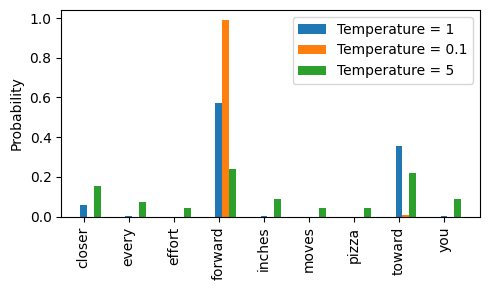

In [12]:
import matplotlib.pyplot as plt 

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize = (5, 3))
for i, T in enumerate(temperature):
    rects = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label = f"Temperature = {T}")

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores. 

In other words, using a temperature of 1 is the same as not
using any temperature scaling. 

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.  

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function. 

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often. 

This can add more variety to the
generated texts but also more often results in nonsensical text. 

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.

In [13]:
# Example logits from a model (size: vocab_size)
logits = torch.tensor([2.0, 1.0, 0.1, 0.5])  # (shape: [vocab_size])
temperature = 0.7

# Scale logits by temperature
scaled_logits = logits / temperature

# Convert to probabilities using softmax
probs = torch.softmax(scaled_logits, dim=-1)

# Sample one token index from the distribution
token_id = torch.multinomial(probs, num_samples=1)

print("Scaled logits:", scaled_logits)
print("Probabilities:", probs)
print("Sampled token index:", token_id.item())


Scaled logits: tensor([2.8571, 1.4286, 0.1429, 0.7143])
Probabilities: tensor([0.7026, 0.1684, 0.0466, 0.0824])
Sampled token index: 1


# DECODING STRATEGY 2: Top-k sampling

In the previous section, we implemented a probabilistic sampling approach coupled with
temperature scaling to increase the diversity of the outputs. 

We saw that higher
temperature values result in more uniformly distributed next-token probabilities, which
result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting
the most probable token. 

This method allows for exploring less likely but potentially more
interesting and creative paths in the generation process. 

However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely nonsensical
outputs such as "every effort moves you pizza".

Top-k sampling, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.

In [14]:
top_k = 3 
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(f"Top Logits: {top_logits}")
print(f"Top Positions: {top_pos}")

Top Logits: tensor([6.7500, 6.2800, 4.5100])
Top Positions: tensor([3, 7, 0])


logit values of tokens that are below the lowest logit value within our top-3 selection to negative infinity (-inf).

In [15]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [16]:
topk_probas = torch.softmax(new_logits, dim = 0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Merge Temperature Scaling and Top-k sampling

In [17]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [20]:
from GPT.Text_Generation import generate
from GPT.GPT_Model import GPTModel
from GPT.Tokenization import text_to_tokens, token_to_text
import tiktoken
import json

In [21]:
with open("../GPT_Model_Configuration/GPT_config_355M.json", "r") as f:
    GPT_CONFIG_355M = json.load(f)

In [23]:
model = GPTModel(GPT_CONFIG_355M)
tokenizer = tiktoken.get_encoding('gpt2')

In [24]:
token_ids = generate(
    model=model, 
    idx = text_to_tokens("Every efforts moves you", tokenizer=tokenizer),
    max_new_tokens=15, 
    context_size=GPT_CONFIG_355M["context_length"], 
    top_k = 25, 
    temperature=1.4
)

In [25]:
token_ids

tensor([[ 6109,  4040,  6100,   345, 48664, 36925, 30343, 49826, 18703,  7071,
         35615, 42095, 25975, 33678, 27010, 21476, 34328, 34002, 42493]])

In [26]:
print(f"Output Text:\n {token_to_text(token_ids, tokenizer)}")

Output Text:
 Every efforts moves you Tend Bowser overflowiliate increment interface Violent Guptaigatorsdelete inflicted…] astounding leveFel
